In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive,interact, HBox, Layout,VBox
from IPython.display import display, clear_output
import os
from datetime import datetime


CSI_Header = ['Date', 'Source', 'Source-ID', 'Open', 'High', 'Low', 'AdjustedClose', 'Close', 'Volume', 'Contract']
data_files = os.listdir('./data')
subset = []
date_col = "Date"
ret_col = "LRN"
style = {'description_width': 'initial'}

In [2]:
def dfReader(file):
    global df, fileName
    fileName = file
    file_path = "./data/" + fileName
    # load csv into a dataframe
    df = pd.read_csv(file_path, names=CSI_Header)
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)


In [3]:
def getColumns(dependentVar, windowSize):
    global value_col
    value_col = dependentVar
    # Calculate additional columns of interest
    df["SMA"] = df[value_col].rolling(window=windowSize).mean()
    df["EWMA"] = df[value_col].ewm(span=windowSize, adjust=False).mean()
    df["SRN"] = df[value_col].pct_change()
    df["LRN"] = np.log(df[value_col] / df[value_col].shift(1))
    df['cum_SRN'] = df["SRN"].cumsum()
    df['cum_LRN'] = df["LRN"].cumsum()
    
    
    ## Exponential moving average strategy calcualtions
    df["EWMA_100"] = df[value_col].ewm(span=100, adjust=False).mean()
    df['Position'] = np.where(df['EWMA_100'] > df['EWMA'], 1, 0) #1 if long, 0 if flat
    df['Position'] = df['Position'].shift()
    df['StrategyPct'] = df[value_col].pct_change(1) * df['Position']
    df['Strategy'] = (df['StrategyPct'] + 1).cumprod()
    df['BuyHold'] = (df[value_col].pct_change(1) + 1).cumprod()
    
    
    ## Simple moving average strategy calcualtions
    df["SMA_100"] = df[value_col].rolling(window=100).mean()
    df['PositionSMA'] = np.where(df['SMA'] > df['SMA_100'], 1, 0)
    df['PositionSMA'] = df['PositionSMA'].shift()
    df['StrategyPctSMA'] = df[value_col].pct_change(1) * df['PositionSMA']
    df['StrategySMA'] = (df['StrategyPctSMA'] + 1).cumprod()
    df['BuyHoldSMA'] = (df[value_col].pct_change(1) + 1).cumprod()

In [4]:
def plot_timeseries(showVar, MA_cols, strat_cols):
    
    clear_output(wait=True)
    # plot the main variable, plus additional moving averages or strategies
    plotCols = [value_col]
    if not showVar:
        plotCols.pop()
    
    for i in range (len(MA_cols)):
        plotCols.append(MA_cols[i])
    for j in range (len(strat_cols)):
        plotCols.append(strat_cols[j])
        
    subset[plotCols].plot(figsize=(10,6))    
    plt.title('Time Series Plot for ' + fileName)
    plt.xlabel(date_col)
    plt.ylabel(value_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [5]:
def timeSeries(dependentVar, showVar, windowSize, MA_cols, strat_cols, start, end):
    global subset
    subset = df[start:end]
    getColumns(dependentVar, windowSize)
    plot_timeseries(showVar, MA_cols, strat_cols)
    

# Select file to analyse

In [6]:
# FILE SELECT WIDGET - has to run before rest of processing
file_select = widgets.Dropdown(options=data_files, value=data_files[0], description="Select file", disabled=False)
widgets.interactive(dfReader, file=file_select)


interactive(children=(Dropdown(description='Select file', options=('CSI_C_1.csv', 'CSI_ES_1.csv', 'CSI_HG_1.cs…

In [7]:
# WIDGETS
widget_info = widgets.Text(value="Use shift-click to multi-select moving averages", style=style, disabled=False)
value_widget = widgets.Dropdown(options=CSI_Header[3:len(CSI_Header)-1], value='Close', description="Select variable", style=style, disabled=False)
var_toggle = widgets.Checkbox(value=True, description='Toggle var', disabled=False, indent=False)
window_slider = widgets.IntSlider(min=10, max=500, step=1, description="MA Window Size", value=300, style=style)
MA_select = widgets.SelectMultiple(options=["SMA", "SMA_100", "EWMA", "EWMA_100"], rows=4, value=[], description="Select MA", disabled=False)
strat_widget = widgets.SelectMultiple(options=["Strategy", "BuyHold", "StrategySMA", "BuyHoldSMA"], rows=4, value=[], description="Select strategies", style=style, disabled=False)
start_widget = widgets.DatePicker(description="Start Date", value=df.index[0])
end_widget = widgets.DatePicker(description="End Date", value=df.index[-1])

display(widget_info)
widgets.interactive(timeSeries, dependentVar=value_widget, showVar=var_toggle, windowSize=window_slider, MA_cols=MA_select, strat_cols=strat_widget, start=start_widget, end=end_widget)

Text(value='Use shift-click to multi-select moving averages', style=TextStyle(description_width='initial'))

interactive(children=(Dropdown(description='Select variable', index=4, options=('Open', 'High', 'Low', 'Adjust…

In [8]:
dfNEW = pd.read_csv('./data/CSI_C_1.csv', names=CSI_Header)
dates = pd.to_datetime(dfNEW['Date'])

<Axes: xlabel='Date'>

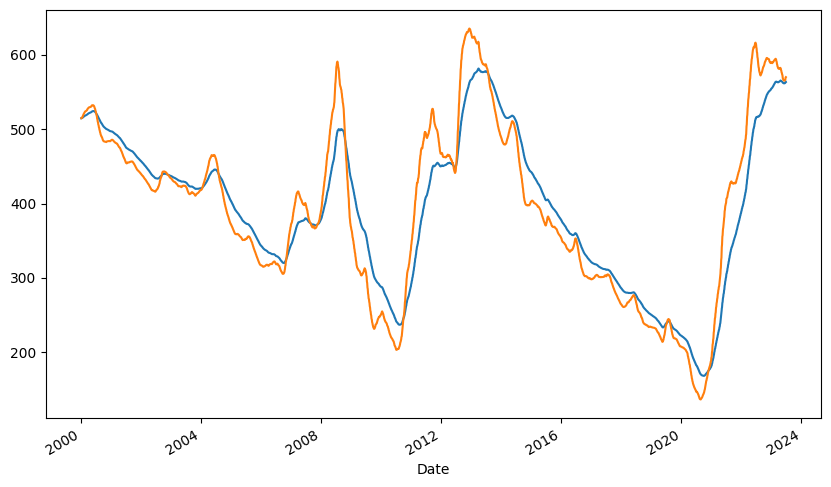

In [9]:
EWMA = df['EWMA']
EWMA100 = df['EWMA_100']

EWMA.plot(figsize=(10,6))
EWMA100.plot(figsize=(10,6))


In [10]:
intersection_dates = []

for i in range(1, len(dates)):
    if (EWMA[i - 1] < EWMA100[i - 1] and EWMA[i] > EWMA100[i]) or \
       (EWMA[i - 1] > EWMA100[i - 1] and EWMA[i] < EWMA100[i]):
        intersection_dates.append(dates[i])
        

In [21]:
buySellToggle = True #true means buy, false means sell
BALANCE = 100
SHARES = 0
risk = []

for i in range (len(intersection_dates)-1):
    
    curDate = intersection_dates[i].strftime('%Y-%m-%d')
    curDatedf = dfNEW[dfNEW['Date'] == curDate]
    close_value = curDatedf['Close'].tolist()[0]
    
    # risk calculations
    cumdf = dfNEW[dfNEW['Date'] <= curDate]
    variance = cumdf['Close'].var()
    risk.append([curDate, close_value / variance])
        
    if not buySellToggle:
        #SELL
        BALANCE = SHARES * close_value
        SHARES = 0
        buySellToggle = True
        print ("BALANCE: " + str(BALANCE) + " - sold on " + curDate)
        
    else:
        #BUY
        SHARES = BALANCE / close_value
        BALANCE = 0
        buySellToggle = False
        print ("SHARES: " + str(SHARES) + " - bought on " + curDate)

        
# buying today to see how much money we would have
# or selling today to see how many shreas we would have
today_df = dfNEW[dfNEW['Date'] == dates.tolist()[-1].strftime('%Y-%m-%d')]
curPrice = today_df['Close'].tolist()[0]
        
if (BALANCE == 0):
    BALANCE = SHARES * curPrice
    
if (SHARES == 0):
    SHARES = BALANCE / curPrice

print ("\nFINAL SHARES: " + str(SHARES))
print ("FINAL MONEY: " + str(BALANCE))


SHARES: 0.20671834625322996 - bought on 2000-06-30
BALANCE: 98.55297157622738 - sold on 2002-09-09
SHARES: 0.22879389802954703 - bought on 2002-11-18
BALANCE: 102.84285716428138 - sold on 2004-01-16
SHARES: 0.2671243043228088 - bought on 2004-07-30
BALANCE: 105.44731913142878 - sold on 2006-11-02
SHARES: 0.2918956930973807 - bought on 2007-08-21
BALANCE: 113.10958107523503 - sold on 2007-11-20
SHARES: 0.3307297692258334 - bought on 2008-10-21
BALANCE: 106.08157347918606 - sold on 2010-09-29
SHARES: 0.2707889559136849 - bought on 2012-05-29
BALANCE: 145.54906380360563 - sold on 2012-06-29
SHARES: 0.2790969583961757 - bought on 2013-07-26
BALANCE: 73.89091973538751 - sold on 2019-07-10
SHARES: 0.35869378512324035 - bought on 2019-08-16

FINAL SHARES: 0.35869378512324035
FINAL MONEY: 211.00161909874615


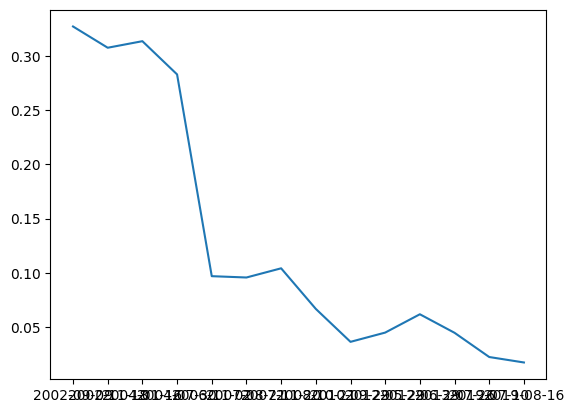

In [24]:
riskDates = []
riskValues = []
i = 0

for elem in risk:
    # ignore the risk of the inital purchase
    if not i == 0:
        riskDates.append(elem[0])
        riskValues.append(elem[1])
    i += 1

plt.plot(riskDates, riskValues)